# CNN Model for SVHN Dataset 32 x 32 Images

Classifying SVHN dataset by using CNN

In [1]:
import os
import time
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

/home/manhduy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/manhduy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/manhduy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/manhduy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

## Loading Data .....

In [3]:
# Open the file as readonly
h5f = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (63733, 32, 32, 1) (63733, 10)
Validation set (9524, 32, 32, 1) (9524, 10)
Test set (26032, 32, 32, 1) (26032, 10)


## Plotting n rows x m col
` Plot random images from passed data`

In [4]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

### Get Batch Dynamically

In [6]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

### Placeholder Variable

`Using placeholder var whose value can directly
feed to the graph`

In [7]:
comp = 32*32
tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
y_cls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## CNN Architecture function

Using Basic ConvNet Architecture

`INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC`

In [8]:
def cnn_model_fn(features):
    """Model function for CNN."""
    
      # Input Layer
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

      # Convolutional Layer #1
    #with tf.name_scope('Conv1 Layer + ReLU'):
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

      # Pooling Layer #1
    #with tf.name_scope('Pool1 Layer'):
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2 and Pooling Layer #2
    #with tf.name_scope('Conv2 Layer + ReLU'): 
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    #with tf.name_scope('Pool2 Layer'):
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
         inputs=dense, rate=discard_rate)

      # Logits Layer
    #with tf.name_scope('Logits Layer'):
    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits


In [9]:
max_epochs = 2
num_examples = X_train.shape[0]

In [10]:
prepare_log_dir()

### Prediction and Optimizer

`Loss calculated for each iteration using prediction
from "cnn_model_fn()" results`

`Optimizer used is  Adam Optimizer`

In [11]:
#with tf.name_scope('Model Prediction'):
prediction = cnn_model_fn(x)
prediction_cls = tf.argmax(prediction, 1)
#with tf.name_scope('loss'):
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
   onehot_labels=y, logits=prediction))
    #tf.summary.scalar('loss', loss)
    
#with tf.name_scope('Adam Optimizer'):
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Accuracy

`Calculate total prediction and also
cal accuracy of passed data`

In [12]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(prediction_cls, y_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
#merged_summary = tf.summary.merge_all()

## Tensorflow Session

In [14]:
sess = tf.Session()

In [15]:
sess.run(tf.global_variables_initializer())

### Saver Object

`Used for storing and reterving variable pesent 
in graph`

In [16]:
saver = tf.train.Saver()

save_dir = 'checkpnts/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

### Restoring the variable

In [17]:
#saver.restore(sess=session, save_path=save_path)

### Initialized Variable

In [18]:
## No of example in each batch for updating weights
batch_size = 512

#Discarding or fuse % of neurons in Train mode
discard_per = 0.7

In [19]:
#with tf.Session() as sess:
 #   sess.run(tf.global_variables_initializer())
    
## To calculate total time of training
train_loss = []
valid_loss = []
start_time = time.time()
for epoch in range(max_epochs):
    print ('Training .........')
    epoch_loss = 0
    print ()
    print ('Epoch ', epoch+1 , ': ........ \n')
    step = 0   
    
    ## Training epochs ....
    for (epoch_x , epoch_y) in get_batch(X_train, y_train, batch_size):
        _, train_accu, c = sess.run([optimizer, accuracy, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: discard_per})
        train_loss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')

            ## Validating prediction and summaries
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(X_val, y_val, 512):                            
                correct, _c = sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                valid_loss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy :' , accu*100.0/y_val.shape[0], '%')
            print ()
        step = step + 1


    print ('Epoch', epoch+1, 'completed out of ', max_epochs)

    
## Calculate net time
time_diff = time.time() - start_time

## Testing prediction and summaries
accu = 0.0
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accu+= np.sum(correct[correct == True])
print('Test Accuracy :' , accu*100.0/y_test.shape[0], '%')
print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
print ()

Training .........

Epoch  1 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  2.321352
Mini-Batch Accuracy : 13.4765625 %
Validation Accuracy : 19.361612767744646 %

Step: 40 ..... 
Mini-Batch Loss   :  1.1300983
Mini-Batch Accuracy : 65.4296875 %
Validation Accuracy : 69.31961360772785 %

Step: 80 ..... 
Mini-Batch Loss   :  0.6360353
Mini-Batch Accuracy : 80.2734375 %
Validation Accuracy : 81.86686266274674 %

Step: 120 ..... 
Mini-Batch Loss   :  0.51999974
Mini-Batch Accuracy : 84.5703125 %
Validation Accuracy : 85.13229735405292 %

Epoch 1 completed out of  2
Training .........

Epoch  2 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.51282984
Mini-Batch Accuracy : 85.9375 %
Validation Accuracy : 84.49181016379673 %

Step: 40 ..... 
Mini-Batch Loss   :  0.51945424
Mini-Batch Accuracy : 85.9375 %
Validation Accuracy : 85.11129777404452 %

Step: 80 ..... 
Mini-Batch Loss   :  0.44257188
Mini-Batch Accuracy : 87.3046875 %
Validation Accuracy : 86.93826123477531 %

Step: 120 ..... 

In [20]:
"""accu = 0.0
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    predcls, classy = sess.run([prediction_cls, y_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accumulate = np.sum((predcls == classy)*1)
    crct = np.sum(correct[correct == True])
    deaccumulate = np.sum((predcls != classy)*1)
    accu+= accumulate
    print('Test Accuracy :' , accumulate, crct, deaccumulate, accumulate+ deaccumulate, y_test.shape[0], '%')
print ()
"""

"accu = 0.0\nfor (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):\n    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})\n    predcls, classy = sess.run([prediction_cls, y_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})\n    accumulate = np.sum((predcls == classy)*1)\n    crct = np.sum(correct[correct == True])\n    deaccumulate = np.sum((predcls != classy)*1)\n    accu+= accumulate\n    print('Test Accuracy :' , accumulate, crct, deaccumulate, accumulate+ deaccumulate, y_test.shape[0], '%')\nprint ()\n"

** To save the model Checkpoints **

In [21]:
saver.save(sess=sess, save_path=save_path)

'checkpnts/svhn_single_greyscale'

# Model Visualization

** Plot different confusion map and images **

** to get insights of how our model is performing **

###  Plotting Train Actual Images
` Plot 3 rows x 6 col images randomly
with their true labels`

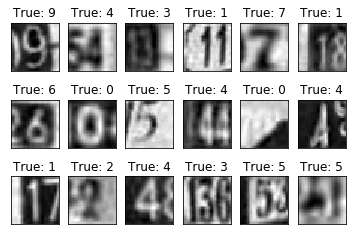

In [22]:
plot_images(X_train, 3, 6, y_train);

`Evaluate predicted class from test data`

In [23]:
test_pred = []
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([prediction_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    test_pred.append((np.asarray(correct, dtype=int)).T)

print ('Completed')

Completed


#### Convert Lists of List to numpy array
` compatiable with y_label`

In [24]:
def flatten(lists):
    results = []
    for numbers in lists:
        for x in numbers:
            results.append(x)
    return np.asarray(results)

In [25]:
flat_array = flatten(test_pred)
flat_array = (flat_array.T)
flat_array = flat_array[0]

In [26]:
flat_array.shape

(26032,)

### Confusion Metric

>**I got that concept wrong in one interview, so kindly search about it; 
>**

`Plot and see the misclassfied results of model`

In [42]:
y_true=np.argmax(y_test, axis=1)

In [46]:
y_true

array([5, 2, 1, ..., 7, 6, 7])

In [35]:
type(flat_array)

numpy.ndarray

In [37]:
print(y_true.shape),print(flat_array.shape)

(26032,)
(26032,)


(None, None)

In [38]:
print(y_true)
print(flat_array)

[5 2 1 ... 7 6 7]
[5 2 1 ... 7 6 7]


In [51]:
y_true=np.argmax(y_test, axis=1)

In [52]:
y_true

array([5, 2, 1, ..., 7, 6, 7])

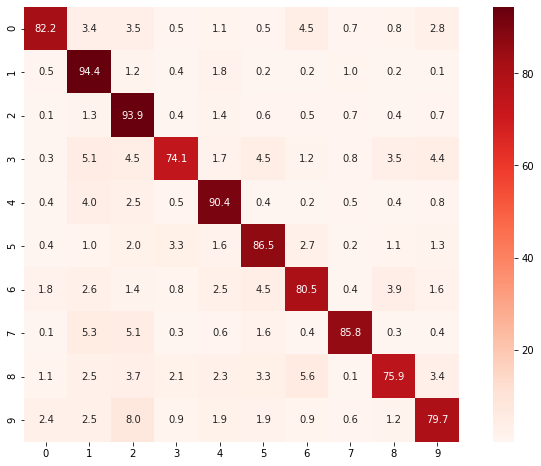

In [47]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=flat_array)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

### Plotting Misclassified results

`Plot the misclassfied images of randomly sampled
from test set`

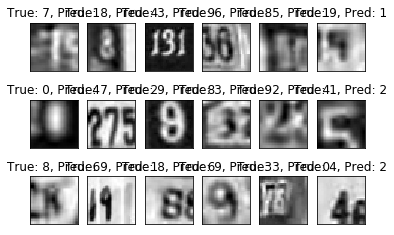

In [28]:
# Find the incorrectly classified examples
incorrect = flat_array != np.argmax(y_test, axis=1)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = flat_array[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

### Plotting Correctly classified results

`Plot the correctly classfied images of randomly sampled
from test set`

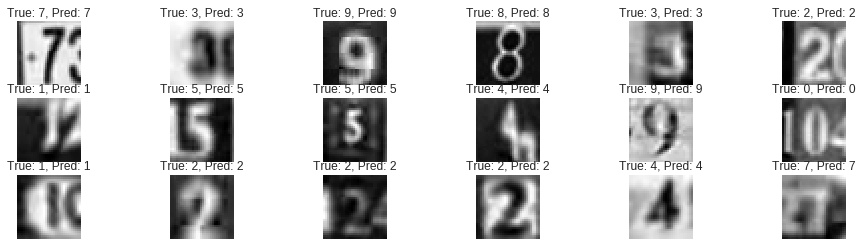

In [32]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = flat_array[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

### Plotting Validation and Training Losses

`Plotting the losses to gurantee that model
is learning good or not`

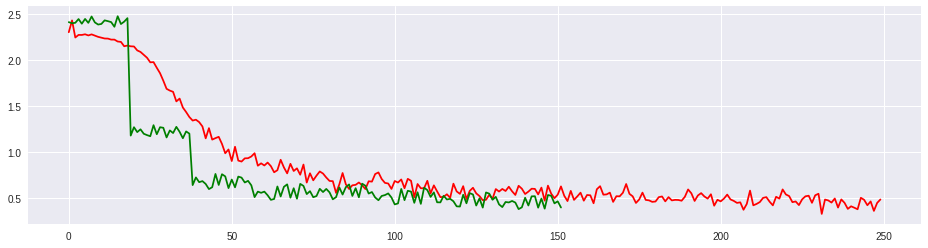

In [134]:
import matplotlib.pyplot as plt
plt.plot(train_loss ,'r')
plt.plot(valid_loss, 'g')